In [90]:
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import nan
from scipy import signal

path='data_dump/2020_reflectometry.hdf5'
path_other='data_dump/2020_other_signals.hdf5'

f = h5py.File(path, 'a')
f_other=h5py.File(path_other, 'a')

In [91]:
def butter_lowpass_filter(data, cutoff, fs, half_order=5, axis=-1):
    """This function applies a linear digital filter twice, once forward and once backwards. 
    The combined filter has zero phase and a filter order twice that of *half_order*.
    
    Parameters
    ----------
    data: ndarray
        Array of data to filter
    cutoff: float
        Cutoff frequency in Hz.
    fs: float
        Sampling frequency in Hz.
    half_order: int
        Half of the filter order.
    axis: int, optional
        The axis of x to which the filter is applied. Default is -1.
        
    Returns
    -------
    y: ndarray
        Filtered array
    """
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(half_order, normal_cutoff, btype='low', output='sos')
    y = signal.sosfiltfilt(sos, data, axis)
    return y

In [92]:
keys1=list(f.keys())

#Choosing the wanted shot
s=3

# Getting data from path 
t0, t1 = f_other[keys1[s]]['FLAT_TOP']
t_max, n_max = f[keys1[s]]['REF']['rho_poloidal_hfs'].shape
rho_h = np.array(f[keys1[s]]['REF']['rho_poloidal_hfs'])
rho_l = np.array(f[keys1[s]]['REF']['rho_poloidal_lfs'])
n= np.array(f[keys1[s]]['REF']['density'])
time = np.array(f[keys1[s]]['REF']['time'])

# Checking indices for the beginning and end of shot plateau
i_t0, i_t1 = (-1, -1)
for ti in range(t_max):
    if time[ti] >= t0:
        if i_t0 == -1:
            i_t0 = ti
        elif time[ti] <= t1:
            i_t1 = ti+1

# Reassignment for plateau time
t_real = i_t1 - i_t0
rho_h=rho_h[i_t0:i_t1,:]
rho_l=rho_l[i_t0:i_t1,:]
time=time[i_t0:i_t1]

limit_hfs = (2.8*10**19,2.95*10**19) 
limit_lfs = (2.4*10**19,2.6*10**19)
labels=np.zeros((t_real,3))
check=np.zeros((t_real,2))

In [93]:
# Creating the labels n_h1, n_l1 and the binary for density front

for t in range(t_real):
    rho_h1 = 2
    n_h1 = 0
    rho_l1 = 2
    n_hl1 = 0
    for i in range(n_max):
        if rho_h[t,i] >= 1 and rho_h[t,i] < rho_h1:
            rho_h1 = rho_h[t,i]
            n_h1 = n[i]
        if rho_l[t,i] >= 1 and rho_l[t,i] < rho_l1:
            rho_l1 = rho_l[t,i]
            n_l1 = n[i]
    check[t,0] = rho_h1
    check[t,1] = rho_l1
    labels[t,0] = n_h1
    labels[t,1] = n_l1
    if n_h1 >= limit_hfs[0] and n_l1 <= limit_lfs[0]:
        labels[t,2]=1
    elif n_h1 >= limit_hfs[1] and n_l1 <= limit_lfs[1]:
        labels[t,2]=1

In [94]:
# Denoising the labels

fs = 1 / ( time[1] - time[0] )  # Sampling frequency
cutoff = 15                     # Frequency cutoff value in Hz
labels_filtered = np.zeros((t_real,3))
check_filtered = np.zeros((t_real,2))
for i in range(2):
    labels_filtered[:,i] = butter_lowpass_filter(labels[:,i], cutoff, fs)
    check_filtered[:,i] = butter_lowpass_filter(check[:,i], cutoff, fs)

for t in range(t_real):
    if labels_filtered[t,0] - labels_filtered[t,1] > 0.6*10**19:
        labels_filtered[t,2]=1
    elif labels_filtered[t,0] >= limit_hfs[1] and labels_filtered[t,0] - labels_filtered[t,1] > 0.4*10**19:
        labels_filtered[t,2]=1
print(fs)

1904.770208900999


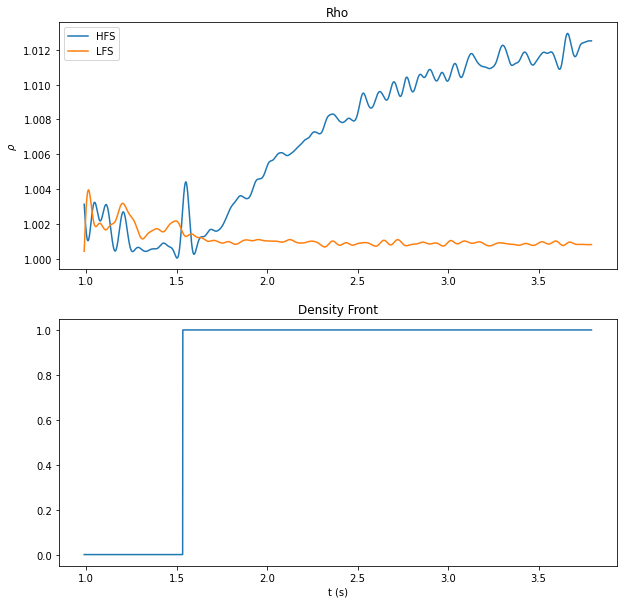

In [107]:
# Plotting results

fig, axs = plt.subplots(2,figsize=(10, 10))
# fig.suptitle('Shot ' + keys1[s], y=0.93, fontsize=16)
# axs[0].plot(time,labels[:,0]*10**-19, label='HFS_no_filter')
# axs[0].plot(time,labels_filtered[:,0]*10**-19, label='HFS')
# axs[0].plot(time,labels_filtered[:,1]*10**-19, label='LFS')
axs[0].plot(time,check_filtered[:,0], label='HFS' )
axs[0].plot(time,check_filtered[:,1],label='LFS')
axs[1].plot(time,labels_filtered[:,2])
# axs[0].set(ylabel=r'$n$ $(10^{19}$ $m^{-3})$', title='Density')
axs[0].set(ylabel=r'$\rho$', title='Rho')
axs[1].set(xlabel='t (s)', title='Density Front')
# axs[0].legend()
axs[0].legend()
plt.savefig('Shot_' + keys1[s] + '_rho.png')
plt.show()

In [96]:
# plt.plot(labels[3,:])
# f.create_dataset(keys[s] + '/REF/label',dtype=np.float32,data=labels)

In [97]:
# del f[keys1[s]+ '/REF/label']
# print('File ' + keys1[s] + '/REF/label' + ' was deleted from data_dump')
# f_other.close()


In [98]:
# del f_other['29310']
# del f_other['41179']
# print('File ' + '41179' + ' was deleted from data_dump')
# # f.close()
# f_other.close()

In [99]:
# Trying several cutoff values

# fs = 1 / ( time[1] - time[0] ) # Sampling frequency
# cutoff = np.arange(5,40,10)    # Range of cutoff values [5,50] Hz
# labels_filtered = np.zeros((3,t_real,3))
# fig, ax = plt.subplots(3,figsize=(10, 8))
# # fig.suptitle('Shot ' + keys1[s], y=1, fontsize=16)
# for i in range(3):
#     labels_filtered[i,:,0] = butter_lowpass_filter(labels[:,0], cutoff[i], fs)
#     ax[i].plot(time, labels[:,0]*10**-19)
#     ax[i].plot(time, labels_filtered[i,:,0]*10**-19,color='firebrick',label='Threshold = %.2f Hz'%(cutoff[i]))
#     ax[i].set(ylabel=r'$n_h$ $(10^{19}$ $m^{-3})$')
#     ax[i].legend()
# ax[0].set(title= 'Density HFS')
# ax[2].set(xlabel= 'time (s)')
# plt.savefig('Shot_' + keys1[s] + '_filtered.png')
# plt.tight_layout()

In [100]:
# keys1=list(f.keys())

# for key in keys1:

#     # Getting data from path 
#     t0, t1 = f_other[key]['FLAT_TOP']
#     t_max, n_max = f[key]['REF']['rho_poloidal_hfs'].shape
#     rho_h = np.array(f[key]['REF']['rho_poloidal_hfs'])
#     rho_l = np.array(f[key]['REF']['rho_poloidal_lfs'])
#     n= np.array(f[key]['REF']['density'])
#     time = np.array(f[key]['REF']['time'])

#     # Checking indices for the beginning and end of shot plateau
#     i_t0, i_t1 = (-1, -1)
#     for ti in range(t_max):
#         if time[ti] >= t0:
#             if i_t0 == -1:
#                 i_t0 = ti
#             elif time[ti] <= t1:
#                 i_t1 = ti+1

#     # Reassignment for plateau time
#     t_real = i_t1 - i_t0
#     rho_h=rho_h[i_t0:i_t1,:]
#     rho_l=rho_l[i_t0:i_t1,:]
#     time=time[i_t0:i_t1]

#     fs = 1 / ( time[1] - time[0] )  # Sampling frequency
#     cutoff = 15                     # Frequency cutoff value in Hz
#     limit_hfs = (2.8*10**19,2.95*10**19) 
#     limit_lfs = (2.4*10**19,2.6*10**19)
#     labels=np.zeros((t_real,3))
#     check=np.zeros((t_real,2))
#     labels_filtered = np.zeros((t_real,3))
#     check_filtered = np.zeros((t_real,2))

#     for t in range(t_real):
#         rho_h1 = 2
#         n_h1 = 0
#         rho_l1 = 2
#         n_hl1 = 0
#         for i in range(n_max):
#             if rho_h[t,i] >= 1 and rho_h[t,i] < rho_h1:
#                 rho_h1 = rho_h[t,i]
#                 n_h1 = n[i]
#             if rho_l[t,i] >= 1 and rho_l[t,i] < rho_l1:
#                 rho_l1 = rho_l[t,i]
#                 n_l1 = n[i]
#         check[t,0] = rho_h1
#         check[t,1] = rho_l1
#         labels[t,0] = n_h1
#         labels[t,1] = n_l1
#         if n_h1 >= limit_hfs[0] and n_l1 <= limit_lfs[0]:
#             labels[t,2]=1
#         elif n_h1 >= limit_hfs[1] and n_l1 <= limit_lfs[1]:
#             labels[t,2]=1

#     for i in range(2):
#         labels_filtered[:,i] = butter_lowpass_filter(labels[:,i], cutoff, fs)
#         check_filtered[:,i] = butter_lowpass_filter(check[:,i], cutoff, fs)

#     for t in range(t_real):
#         if labels_filtered[t,0] - labels_filtered[t,1] > 0.6*10**19:
#             labels_filtered[t,2]=1
#         elif labels_filtered[t,0] >= limit_hfs[1] and labels_filtered[t,0] - labels_filtered[t,1] > 0.4*10**19:
#             labels_filtered[t,2]=1
#     # f.create_dataset(key+'/REF/labels',dtype=np.float32,data=labels_filtered)
#     # del f[key+'/REF/labels']
# f.close()
# f_other.close()